# Pig islets - Manifold, clustering and endocrine cell analyses

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData
import seaborn as sns
from scipy.sparse import csr_matrix
import xlsxwriter
from matplotlib import rcParams

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.5 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.7.0 leidenalg==0.7.0


In [3]:
sc.set_figure_params(frameon=False)

In [28]:
adata = sc.read('./data/pig_normalized.h5ad')

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  k_to_delete.add(cats_name)
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  k_to_delete.add(cats_name)


## Manifold and clustering all cells

In [110]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


In [111]:
sc.tl.louvain(adata,resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)


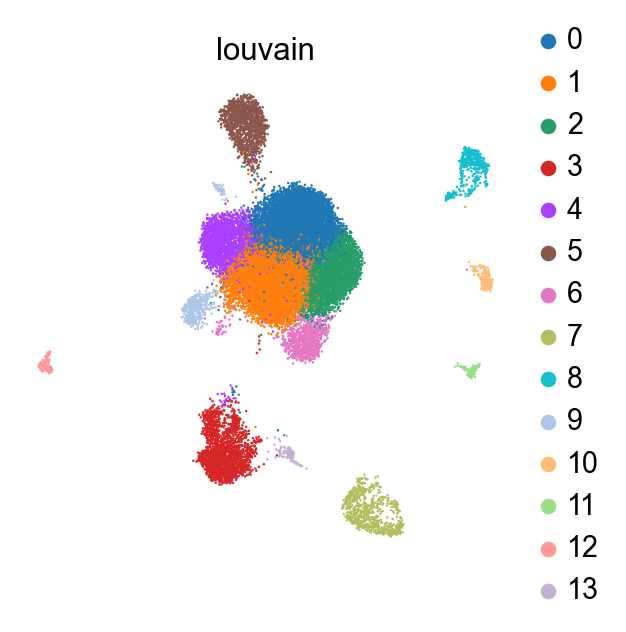

In [112]:
sc.pl.umap(adata,color=['louvain'])

In [273]:
sc.tl.louvain(adata,restrict_to=('louvain',['5']),key_added='louvain_r',resolution=0.3)## refine delta cell clustering
#sc.tl.louvain(adata,restrict_to=('louvain_r',['5,1']),key_added='louvain_r',resolution=0.6)## refine delta cell clustering

sc.tl.louvain(adata,restrict_to=('louvain_r',['3']),key_added='louvain_r',resolution=0.3)## refine delta cell clustering

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_r', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r', the cluster labels (adata.obs, categorical) (0:00:00)


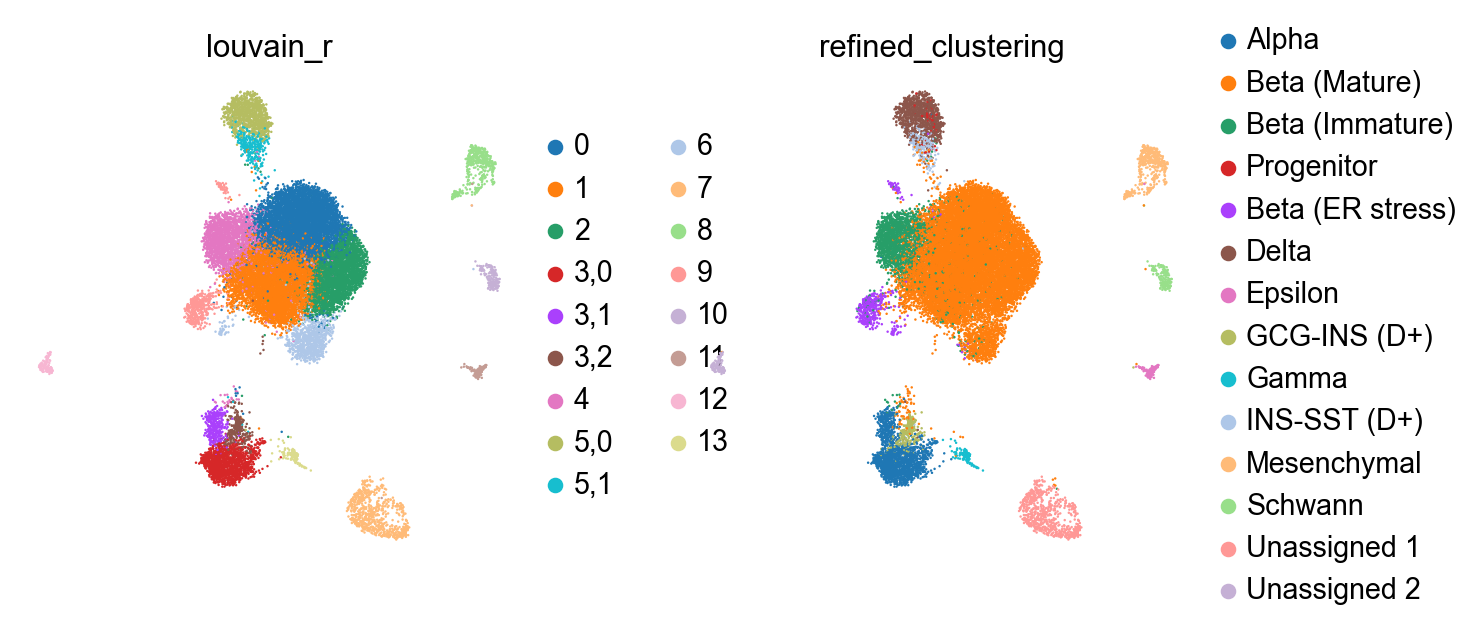

In [274]:
sc.pl.umap(adata,color=['louvain_r', 'refined_clustering'])

In [275]:
map_names = {}
for c in adata.obs['louvain_r'].cat.categories:
    if c in ['0', '1', '2', '4', '9', '6']:
        map_names[c] = 'beta'
    elif c in ['3,0', '3,1']:
        map_names[c] = 'alpha'  
    elif c in ['5,0']:
        map_names[c] = 'delta'
    elif c in ['13']:
        map_names[c] = 'PP'    
    elif c in ['3,2', '5,1']:
        map_names[c] = 'polyhormonal'     
    elif c in ['7']:
        map_names[c] = 'ductal'   
    elif c in ['11']:
        map_names[c] = 'endothelial'
    elif c in ['10']:
        map_names[c] = 'schwann'
    elif c in ['8']:
        map_names[c] = 'fibroblast'
    elif c in ['12']:
        map_names[c] = 'immune' 
    else:
        map_names[c] = c

adata.obs['louvain_anno_broad']=adata.obs['louvain_r']
adata.obs['louvain_anno_broad']=adata.obs['louvain_anno_broad'].map(map_names).astype('category')

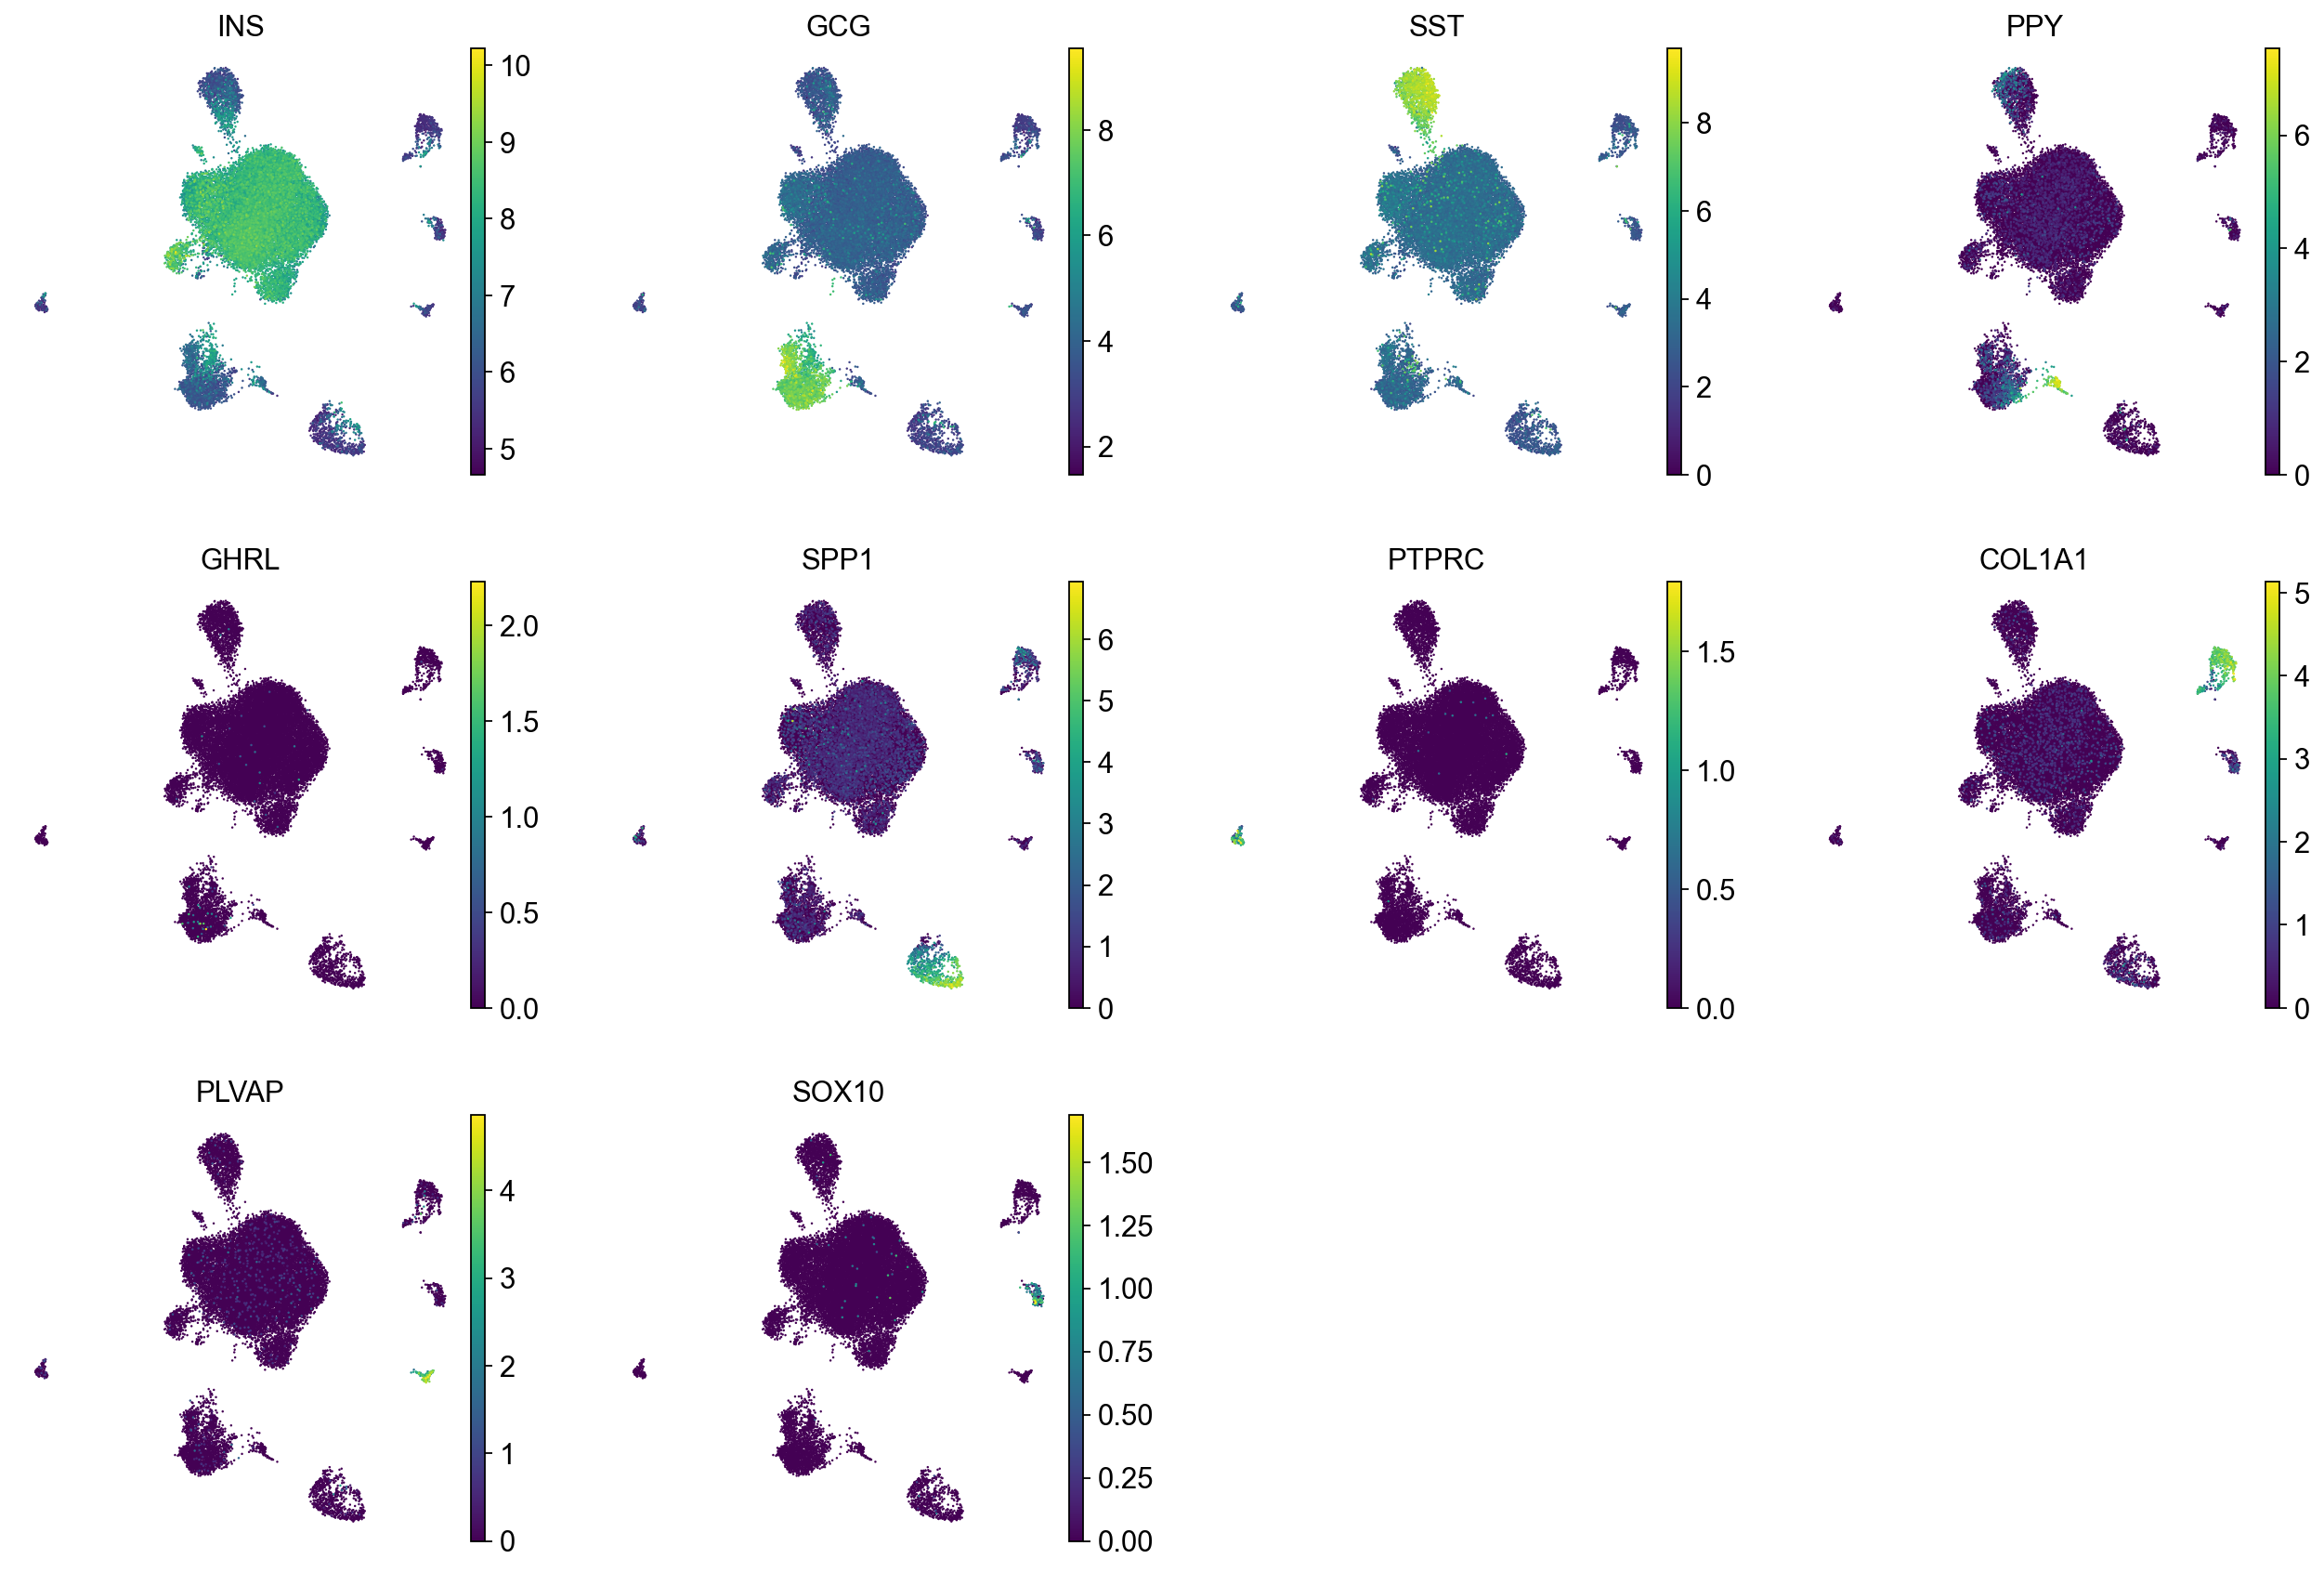

In [152]:
sc.pl.umap(adata, color=['INS', 'GCG', 'SST', 'PPY', 'GHRL', 'SPP1', 'PTPRC', 'COL1A1', 'PLVAP', 'SOX10'])

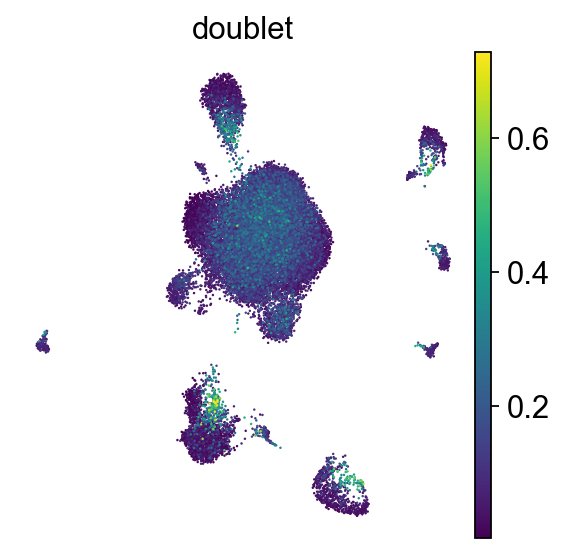

In [261]:
sc.pl.umap(adata,color=['doublet'])

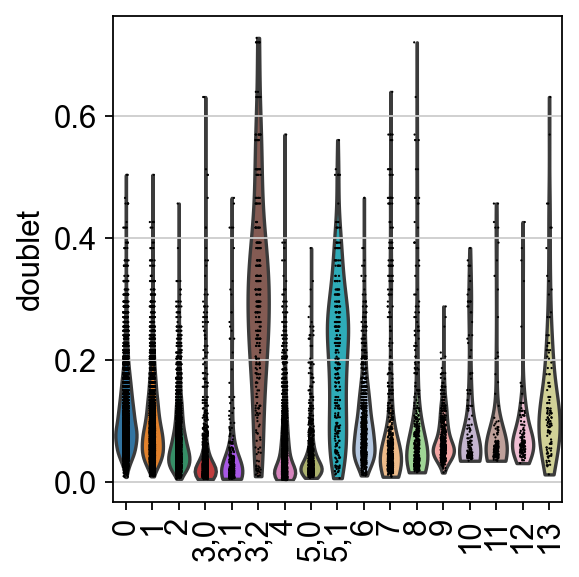

In [276]:
sc.pl.violin(adata,groupby='louvain_r',keys='doublet',rotation=90)

In [277]:
adata.obs['louvain_anno_broad']=adata.obs['louvain_anno_broad'].cat.reorder_categories(['alpha', 'beta','delta','PP', 'polyhormonal',
                                                                                        'ductal',#'acinar',
                                                        'endothelial','fibroblast','immune','schwann'])
adata.uns['louvain_anno_broad_colors']=['#33a02c','#e31a1c','#1f78b4','#b15928','#969696','#fccde5',
                                        '#1b4400','#98df8a','#a6cee3','#8c6bb1']

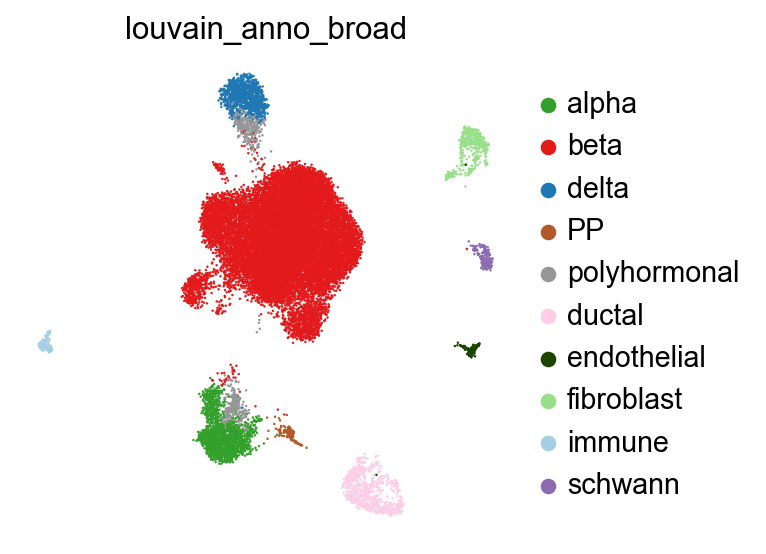

In [278]:
sc.pl.umap(adata,color=['louvain_anno_broad'])

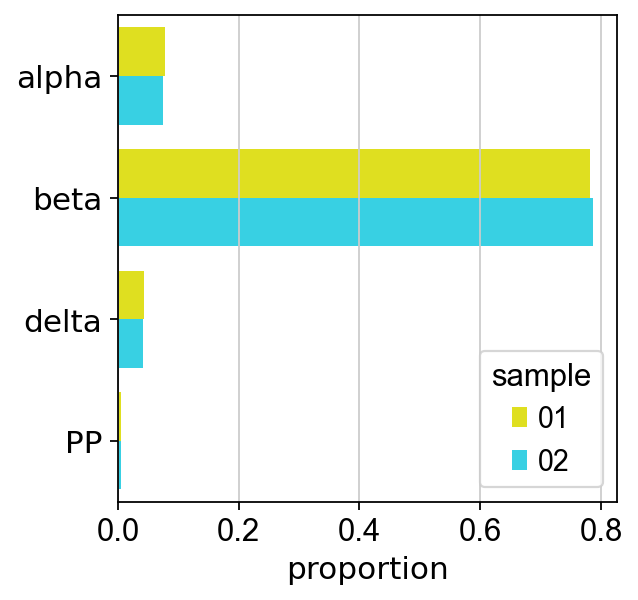

In [159]:
df=adata.obs[['louvain_anno_broad','sample']]
order_cat=['alpha', 'beta', 'delta', 'PP']
pl.subplots()
x='louvain_anno_broad'
hue='sample'
y='proportion'
prop_df = (df[x]
            .groupby(df[hue])
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

sns.barplot(x=y, y=x, hue=hue, data=prop_df,palette=adata.uns['sample_colors'],order=order_cat,orient='h')
pl.xticks(rotation=0,fontsize=14)
pl.yticks(rotation=0,fontsize=14,fontname='Helvetica Light')

pl.ylabel('')
pl.xlabel('proportion',fontsize=14,fontname='Helvetica Light')
#pl.tight_layout()
#pl.legend('')
#pl.savefig('/Users/sophie/Documents/ICB/Projects/2020_10X_specied_comparison/human_islets/figures/endocrine_proportion.pdf',dpi=300)
pl.show()

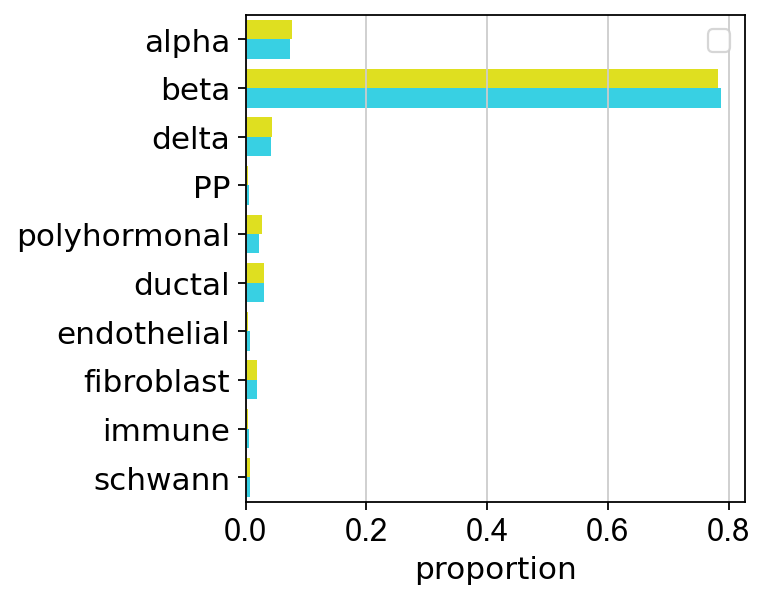

In [160]:
df=adata.obs[['louvain_anno_broad','sample']]

pl.subplots()
x='louvain_anno_broad'
hue='sample'
y='proportion'
prop_df = (df[x]
            .groupby(df[hue])
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

sns.barplot(x=y, y=x, hue=hue, data=prop_df,palette=adata.uns['sample_colors'],orient='h',order=adata.obs['louvain_anno_broad'].cat.categories)
pl.xticks(rotation=0,fontsize=14)
pl.yticks(rotation=0,fontsize=14,fontname='Helvetica Light')

pl.ylabel('')
pl.xlabel('proportion',fontsize=14,fontname='Helvetica Light')
#pl.tight_layout()
pl.legend('')
#pl.savefig('/Users/sophie/Documents/ICB/Projects/2020_10X_specied_comparison/human_islets/figures/endocrine_proportion.pdf',dpi=300)
pl.show()

## Refined manifold and clustering endocrine cells

In [161]:
adata_endo = adata[adata.obs.louvain_anno_broad.isin(['alpha', 'beta', 'delta', 'PP'])].copy()

In [162]:
sc.pp.filter_genes(adata_endo, min_cells=10)

filtered out 336 genes that are detected in less than 10 cells


In [163]:
sc.pp.highly_variable_genes(adata_endo, n_top_genes=2000)
sc.pp.pca(adata_endo)
sc.pp.neighbors(adata_endo)
sc.tl.umap(adata_endo)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [271]:
sc.tl.louvain(adata_endo, resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)


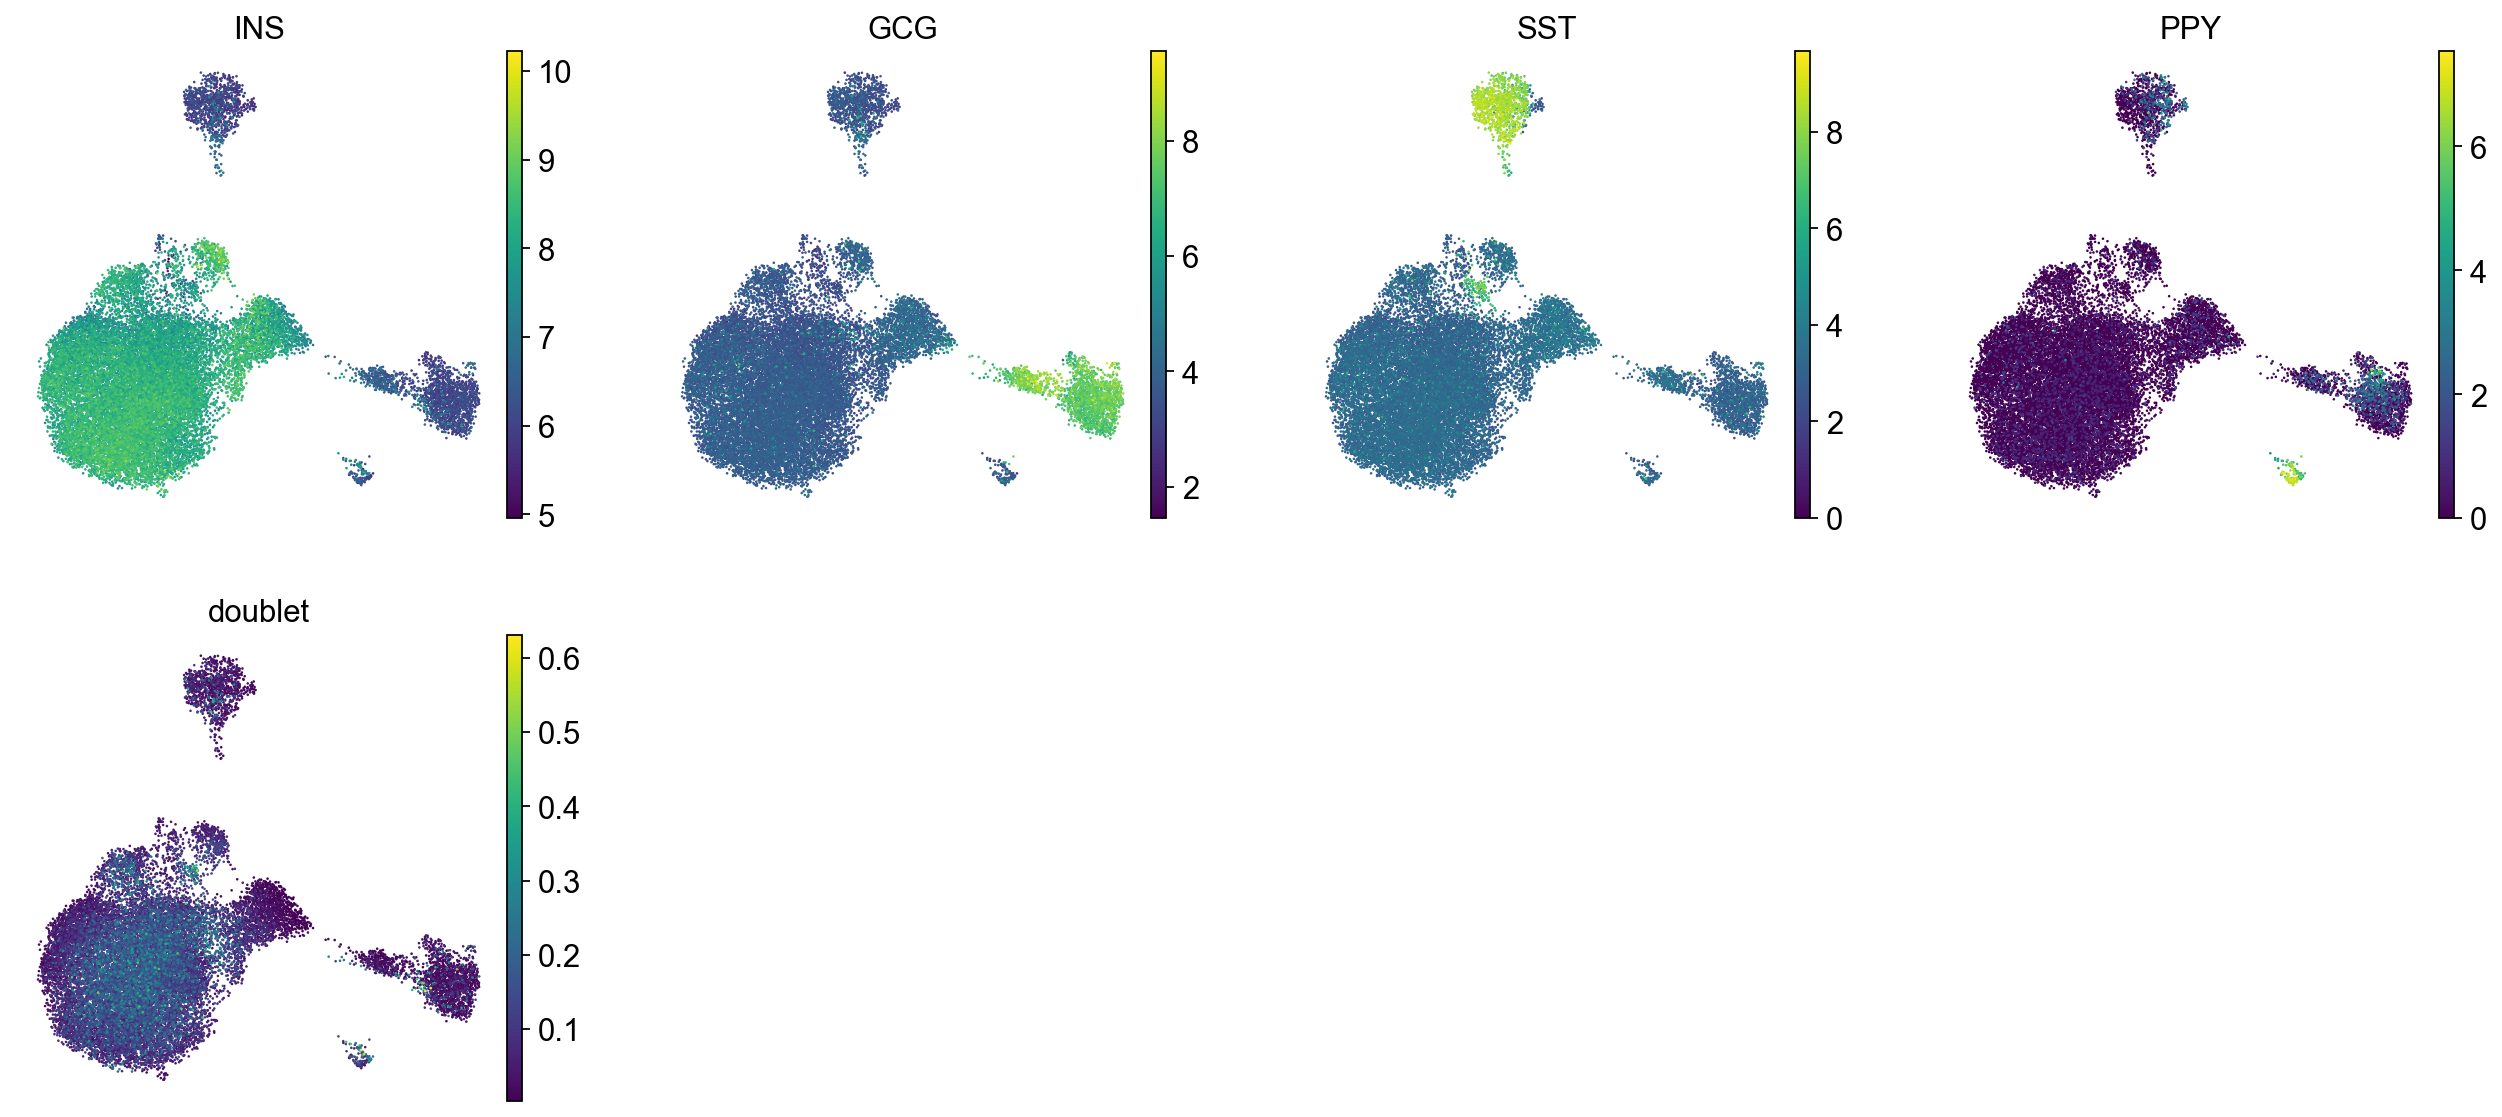

In [353]:
# cluster 12 is polyhormonal
sc.pl.umap(adata_endo, color=['INS', 'GCG', 'SST', 'PPY', 'doublet'])

In [354]:
adata_endo = adata_endo[np.invert(adata_endo.obs.louvain.isin(['12']))].copy()

In [355]:
sc.pp.filter_genes(adata_endo, min_cells=10)
sc.pp.highly_variable_genes(adata_endo, n_top_genes=2000)
sc.pp.pca(adata_endo)
sc.pp.neighbors(adata_endo)
sc.tl.umap(adata_endo)

filtered out 1 genes that are detected in less than 10 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


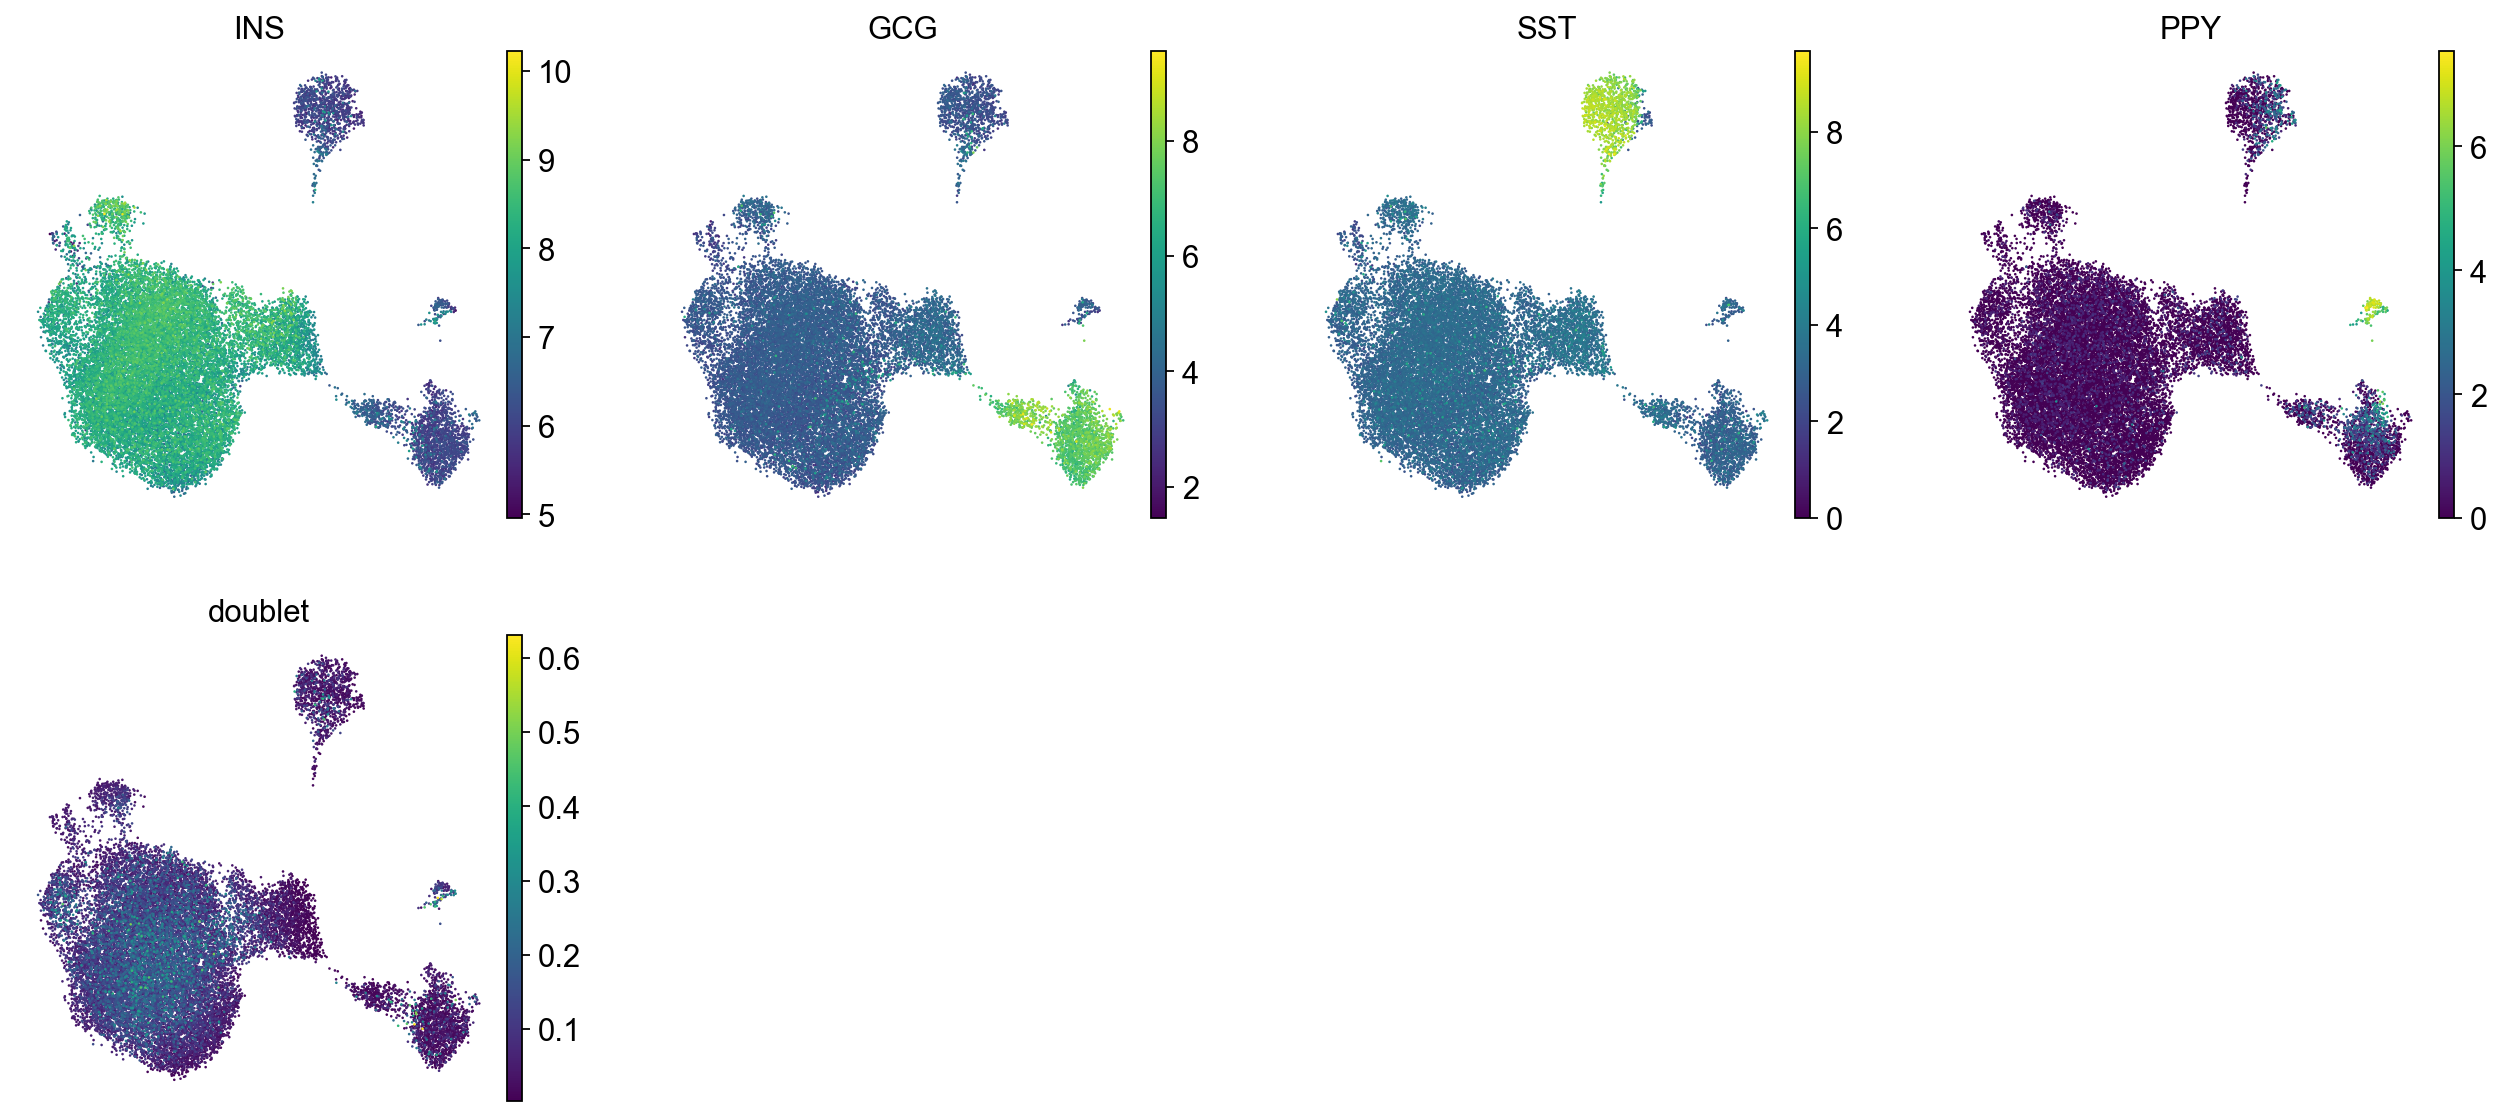

In [356]:
sc.pl.umap(adata_endo, color=['INS', 'GCG', 'SST', 'PPY', 'doublet'])

In [364]:
sc.tl.louvain(adata_endo, resolution=0.5)
sc.tl.louvain(adata_endo, resolution=0.8, restrict_to=('louvain', ['3']), key_added=['louvain_r'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    ['louvain_r'], the cluster labels (adata.obs, categorical) (0:00:00)


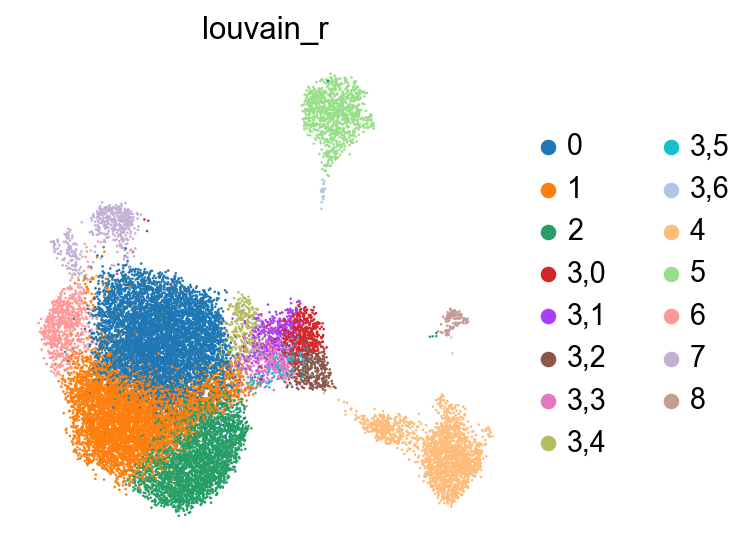

In [368]:
sc.pl.umap(adata_endo, color='louvain_r')

In [372]:
map_names = {}
for c in adata_endo.obs['louvain_r'].cat.categories:
    if c in ['8']:
        map_names[c] = 'PP'
    elif c in ['4']:
        map_names[c] = 'alpha'  
    elif c in ['5', '3,6']:
        map_names[c] = 'delta'
    else:
        map_names[c] = 'beta'    

adata_endo.obs['louvain_anno_broad']=adata_endo.obs['louvain_r']
adata_endo.obs['louvain_anno_broad']=adata_endo.obs['louvain_anno_broad'].map(map_names).astype('category')

In [373]:
adata_endo.obs['louvain_anno_broad']=adata_endo.obs['louvain_anno_broad'].cat.reorder_categories(['alpha', 'beta','delta','PP'])
adata_endo.uns['louvain_anno_broad_colors']=['#33a02c','#e31a1c','#1f78b4','#b15928']

In [8]:
adata_endo.obs[['n_counts', 'n_genes']].median()

n_counts    8831.0
n_genes     1836.0
dtype: float64

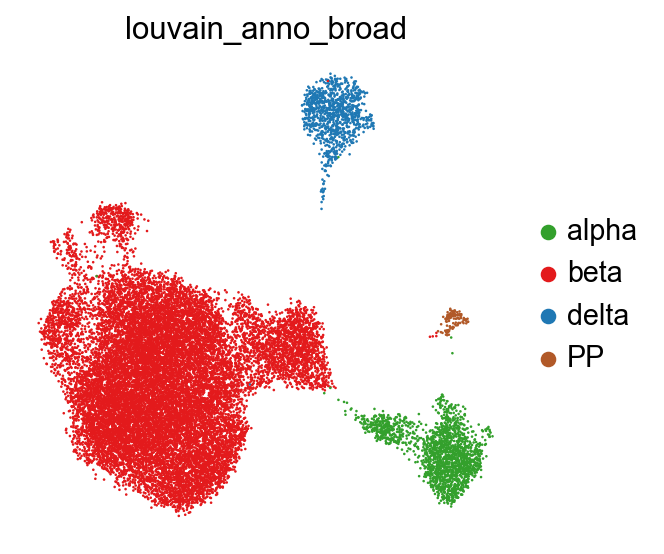

In [6]:
sc.pl.umap(adata_endo, color=['louvain_anno_broad'])

## Composition

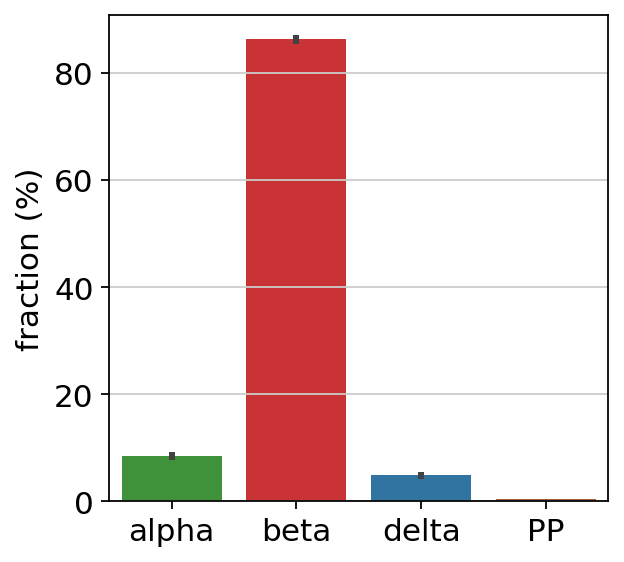

In [16]:
df=adata_endo.obs[['louvain_anno_broad','donor']]
order_cat=['alpha', 'beta', 'delta', 'PP']
pl.subplots()

x='louvain_anno_broad'
y='proportion'
hue='donor'
prop_df = (df[x].groupby(df[hue])
            .value_counts(normalize=True)
            .rename(y)
            .reset_index())

prop_df[y]=prop_df[y]*100

sns.barplot(x='louvain_anno_broad', y=y, data=prop_df,palette=adata_endo.uns['louvain_anno_broad_colors'],order=order_cat,orient='v')
pl.xticks(rotation=0,fontsize=14,fontname='Helvetica Light')
pl.yticks(rotation=0,fontsize=14,fontname='Helvetica Light')

pl.xlabel('')
pl.ylabel('fraction (%)',fontsize=14,fontname='Helvetica Light')
pl.show()

## Expression of endocrine cell type markers

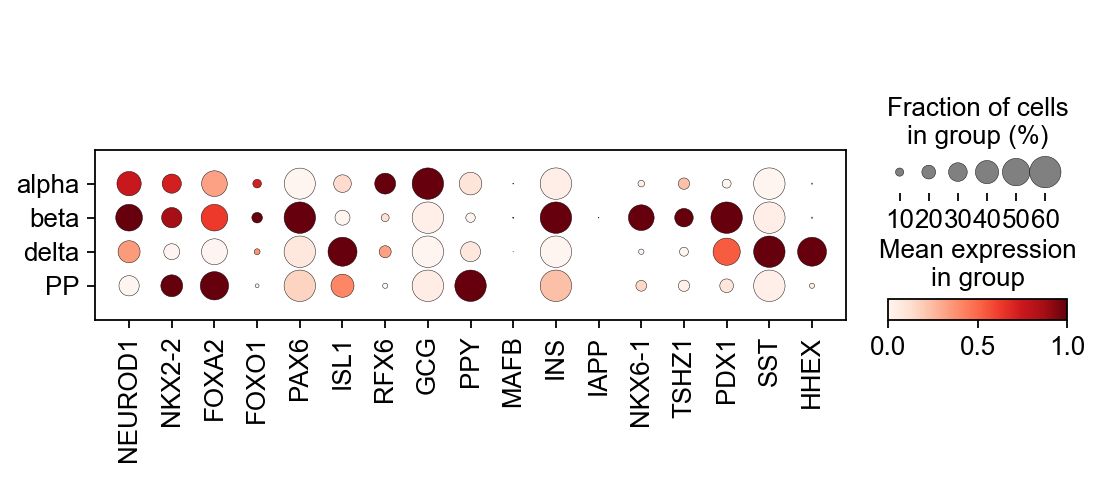

In [15]:
genes=['NEUROD1', 'NKX2-2', 'FOXA2', 'FOXO1', 'PAX6', 'ISL1', 'RFX6', 'GCG',  'PPY',
       'MAFB', 'INS', 'IAPP', 'NKX6-1', 'TSHZ1', 'PDX1',  'SST', 'HHEX']

sc.pl.dotplot(adata_endo, groupby='louvain_anno_broad', var_names=genes, standard_scale='var', dot_max=0.6)

## Identification of enriched endocrine markers

In [376]:
marker_dict_endo=dict()
for group in ['alpha', 'beta', 'delta', 'PP']:
    
    
    refs = ['alpha', 'beta', 'delta', 'PP']
    refs.remove(group)
    # subset to genes expressed in >20% of celltype
    adata_group = adata_endo[adata_endo.obs.louvain_anno_broad.isin([group])].copy()
    
    genes_frac = (adata_group.X > 0).sum(0) / adata_group.n_obs
    
    # subset to genes expressed in >5% of celltype
    if group in ['PP']:
        genes = adata_group.var_names[genes_frac.A1>0.05]
    else:
        genes = adata_group.var_names[genes_frac.A1>0.05]
    
    adata_sub=adata_endo[:,genes].copy()
    
    sc.tl.rank_genes_groups(adata_sub,groupby='louvain_anno_broad',method='t-test',n_genes=adata_sub.n_vars)
    df = sc.get.rank_genes_groups_df(adata_sub, group=group).loc[sc.get.rank_genes_groups_df(adata_sub, group=group)['logfoldchanges']>0.5]
    genes = df['names']
    marker_dict_endo[group]=list(genes)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [377]:
workbook = xlsxwriter.Workbook('/Users/stritschler/Documents/ICB/2020_10X_specied_comparison/pig_islets/marker_dict_endo_enriched.xlsx')

worksheet = workbook.add_worksheet()

row = 0
col = 0

for key in marker_dict_endo.keys():
    row = 0
    worksheet.write(row, col, key)
    for item in marker_dict_endo[key]:
        worksheet.write(row+1, col, item)
        row += 1
    col += 1
workbook.close()